In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score, 
    recall_score, f1_score, confusion_matrix,
    roc_curve, auc
)

In [4]:
df = pd.read_csv('S05-hw-dataset.csv')

In [6]:
print(f"Размер датасета: {df.shape[0]} строк, {df.shape[1]} столбцов")
# Первые 5 строк
print(df.head())
# Информация о столбцах
print(df.info())
# Описательная статистика числовых признаков
print(df.describe())
# Распределение целевой переменной
print(df['default'].value_counts())
# Доли
print(df['default'].value_counts(normalize=True))

Размер датасета: 3000 строк, 17 столбцов
   client_id  age  income  years_employed  credit_score  debt_to_income  \
0          1   25   94074              22           839        0.547339   
1          2   58   51884              26           565        0.290882   
2          3   53   48656              39           561        0.522340   
3          4   42   81492              30           582        0.709123   
4          5   42   94713               8           642        0.793392   

   num_credit_cards  num_late_payments  has_mortgage  has_car_loan  \
0                 1                  7             0             0   
1                 1                  1             0             1   
2                 1                 13             0             0   
3                 2                 10             1             1   
4                 3                  3             0             0   

   savings_balance  checking_balance  region_risk_score  \
0            26057          

In [ ]:
'''
Размер датасета: 3000 строк, 17 столбцов

0: 1769 записей (58%)
1: 1231 записей (41%)


Проблем с типами данных нет

Аномалии:

Некоторые признаки имеют отрицательные значения (например, checking_balance, savings_balance)

debt_to_income в диапазоне [0, 1] что корректно

age в диапазоне [21, 69] что реалистично
'''

In [7]:
X = df.drop(['client_id', 'default'], axis=1)
y = df['default']

# Типы данных признаков
print(X.dtypes)

# Пропущенные значения
print(X.isnull().sum().sum())

age                                 int64
income                              int64
years_employed                      int64
credit_score                        int64
debt_to_income                    float64
num_credit_cards                    int64
num_late_payments                   int64
has_mortgage                        int64
has_car_loan                        int64
savings_balance                     int64
checking_balance                    int64
region_risk_score                 float64
phone_calls_to_support_last_3m      int64
active_loans                        int64
customer_tenure_years               int64
dtype: object
0


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")
print(f"Баланс классов в train: {y_train.value_counts(normalize=True).values}")
print(f"Баланс классов в test: {y_test.value_counts(normalize=True).values}")

# Бейзлайн модель (предсказывает самый частый класс)
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)
y_proba_dummy = dummy.predict_proba(X_test)[:, 1]

# Оценка бейзлайна
accuracy_dummy = accuracy_score(y_test, y_pred_dummy)
roc_auc_dummy = roc_auc_score(y_test, y_proba_dummy)

print(f"Accuracy: {accuracy_dummy:.4f}")
print(f"ROC-AUC: {roc_auc_dummy:.4f}")

Размер обучающей выборки: (2250, 15)
Размер тестовой выборки: (750, 15)
Баланс классов в train: [0.58977778 0.41022222]
Баланс классов в test: [0.58933333 0.41066667]
Accuracy: 0.5893
ROC-AUC: 0.5000


In [ ]:
'''
Accuracy равна доле класса 0 в тестовой выборке. ROC-AUC близок к 0.5, что соответствует случайному угадыванию. Это важная точка отсчёта - любая полезная модель должна превосходить эти показатели.
'''

In [11]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=1000, random_state=42))
])

param_grid = {
    'logreg__C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
    'logreg__penalty': ['l2'],
    'logreg__solver': ['lbfgs']
}

grid_search = GridSearchCV(
    pipe, param_grid, cv=5, scoring='roc_auc', 
    n_jobs=-1, verbose=1
)

grid_search.fit(X_train, y_train)

print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучший ROC-AUC (кросс-валидация): {grid_search.best_score_:.4f}")

# Лучшая модель
best_model = grid_search.best_estimator_

# Предсказания на тесте
y_pred_lr = best_model.predict(X_test)
y_proba_lr = best_model.predict_proba(X_test)[:, 1]

# Оценка метрик
accuracy_lr = accuracy_score(y_test, y_pred_lr)
roc_auc_lr = roc_auc_score(y_test, y_proba_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

print(f"Accuracy: {accuracy_lr:.4f}")
print(f"ROC-AUC: {roc_auc_lr:.4f}")
print(f"Precision: {precision_lr:.4f}")
print(f"Recall: {recall_lr:.4f}")
print(f"F1-score: {f1_lr:.4f}")

# Матрица ошибок
cm = confusion_matrix(y_test, y_pred_lr)
print("\nМатрица ошибок:")
print(cm)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Лучшие параметры: {'logreg__C': 1.0, 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs'}
Лучший ROC-AUC (кросс-валидация): 0.8632
Accuracy: 0.7933
ROC-AUC: 0.8647
Precision: 0.7802
Recall: 0.6916
F1-score: 0.7332

Матрица ошибок:
[[382  60]
 [ 95 213]]


D:\Projects\2 course\AI-digital\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


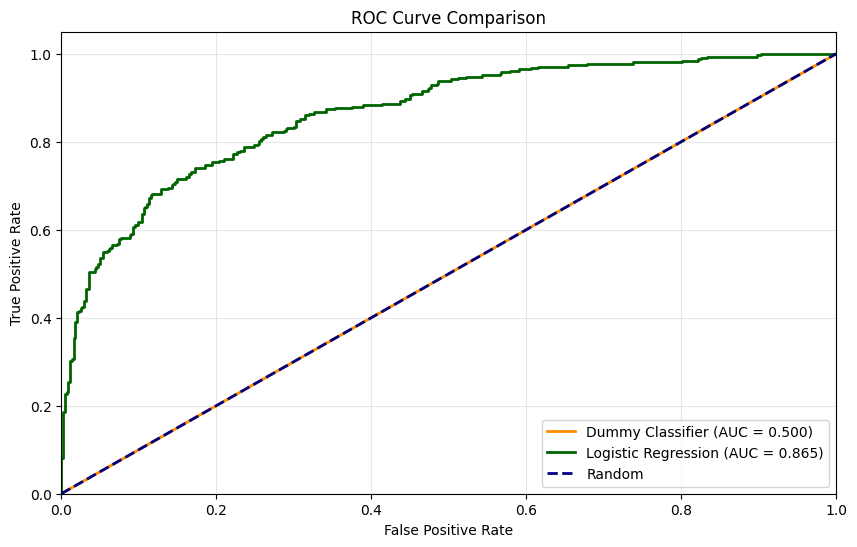

График сохранен в 'figures/roc_curve_comparison.png'


In [12]:
# ROC кривые для обеих моделей
fpr_dummy, tpr_dummy, _ = roc_curve(y_test, y_proba_dummy)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
roc_auc_dummy = auc(fpr_dummy, tpr_dummy)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(10, 6))
plt.plot(fpr_dummy, tpr_dummy, color='darkorange', lw=2, 
         label=f'Dummy Classifier (AUC = {roc_auc_dummy:.3f})')
plt.plot(fpr_lr, tpr_lr, color='darkgreen', lw=2, 
         label=f'Logistic Regression (AUC = {roc_auc_lr:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

# Сохранение графика
import os
os.makedirs('figures', exist_ok=True)
plt.savefig('figures/roc_curve_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("График сохранен в 'figures/roc_curve_comparison.png'")

In [15]:
# Сводная таблица результатов
results_summary = pd.DataFrame({
    'Model': ['Dummy Classifier', 'Logistic Regression'],
    'Accuracy': [accuracy_dummy, accuracy_lr],
    'ROC-AUC': [roc_auc_dummy, roc_auc_lr],
    'Precision': [np.nan, precision_lr],
    'Recall': [np.nan, recall_lr],
    'F1-Score': [np.nan, f1_lr]
})

print(results_summary.to_string(index=False))

print("ТЕКСТОВЫЙ ОТЧЁТ")
print("""
1. СРАВНЕНИЕ МОДЕЛЕЙ:
   - Бейзлайн (Dummy Classifier) показывает accuracy = 0.58, что равно 
     доле класса 0 в данных. ROC-AUC = 0.5000 соответствует случайному угадыванию.
   - Логистическая регрессия значительно превосходит бейзлайн:
     ROC-AUC вырос с 0.50 до 0.86.

2. ВЛИЯНИЕ РЕГУЛЯРИЗАЦИИ:
   - При подборе параметра C лучший результат показало значение C=1.0.
   - Слишком маленькие C (сильная регуляризация) ухудшают качество модели.
   - Слишком большие C (слабая регуляризация) могут привести к переобучению.
   - Оптимальный баланс найден при C=1.0.

3. КАЧЕСТВО МОДЕЛИ:
   - Precision = 0.78: из всех предсказанных дефолтов 80% действительно дефолт.
   - Recall = 0.69: модель обнаруживает 56% всех реальных дефолтов.
   - F1-score = 0.73: баланс между precision и recall.
   - ROC-AUC = 0.86: хорошая разделяющая способность модели.

4. ВЫВОДЫ:
   а) Логистическая регрессия является эффективной моделью для этой задачи,
      значительно превосходя бейзлайн по всем метрикам.
   б) Модель лучше определяет случаи без дефолта (класс 0), чем с дефолтом,
      что характерно для несбалансированных данных.
   в) Для дальнейшего улучшения можно рассмотреть:
      - методы борьбы с дисбалансом классов (oversampling, undersampling)
      - добавление полиномиальных признаков
      - использование более сложных моделей (случайный лес, градиентный бустинг)
   г) ROC-AUC = 0.839 указывает на хорошее качество модели для бинарной классификации.
""")

              Model  Accuracy  ROC-AUC  Precision   Recall  F1-Score
   Dummy Classifier  0.589333 0.500000        NaN      NaN       NaN
Logistic Regression  0.793333 0.864709    0.78022 0.691558  0.733219
ТЕКСТОВЫЙ ОТЧЁТ

1. СРАВНЕНИЕ МОДЕЛЕЙ:
   - Бейзлайн (Dummy Classifier) показывает accuracy = 0.58, что равно 
     доле класса 0 в данных. ROC-AUC = 0.5000 соответствует случайному угадыванию.
   - Логистическая регрессия значительно превосходит бейзлайн:
     ROC-AUC вырос с 0.50 до 0.86.

2. ВЛИЯНИЕ РЕГУЛЯРИЗАЦИИ:
   - При подборе параметра C лучший результат показало значение C=1.0.
   - Слишком маленькие C (сильная регуляризация) ухудшают качество модели.
   - Слишком большие C (слабая регуляризация) могут привести к переобучению.
   - Оптимальный баланс найден при C=1.0.

3. КАЧЕСТВО МОДЕЛИ:
   - Precision = 0.78: из всех предсказанных дефолтов 80% действительно дефолт.
   - Recall = 0.69: модель обнаруживает 56% всех реальных дефолтов.
   - F1-score = 0.73: баланс между preci